In [2]:
import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import scipy
import os

from utils import plot_histogram
from var import sc_data_folder, results_folder, today, color

In [3]:
#set seed to 0 for reproducibility of results
np.random.seed(0)

In [4]:
#Create figures folder
figures_folder = os.path.join(results_folder, 'figures/perturbed_rna_exploration/')
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

<h3> 1. Data exploration of filtered data </h3>

In [5]:
#load log normlised adata object with filter for cells with more than 5000 UMI counts expressed
adata_preprocessed = sc.read_h5ad(f'/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/results/20230116_adata_pre_processed.h5ad')

In [6]:
#load adata obs object from crispra csv file
adata_obs_df=pd.read_csv('/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/data/crispra_data_exploration/20230127_perturbation_state.csv', index_col=0)
#order index of adata_obs_df to match adata_preprocessed
adata_obs_df = adata_obs_df.reindex(adata_preprocessed.obs.index)
#check that the index of adata_obs_df matches adata_preprocessed
assert adata_obs_df.index.equals(adata_preprocessed.obs.index)
#overwrite adata_preprocessed.obs with adata_obs_df
adata_preprocessed.obs = adata_obs_df

#filter out cells that are not in the perturbation state
adata_pertubed = adata_preprocessed[adata_preprocessed.obs['perturbation_state'] != 'not_perturbed']

/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/tools/_leiden.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

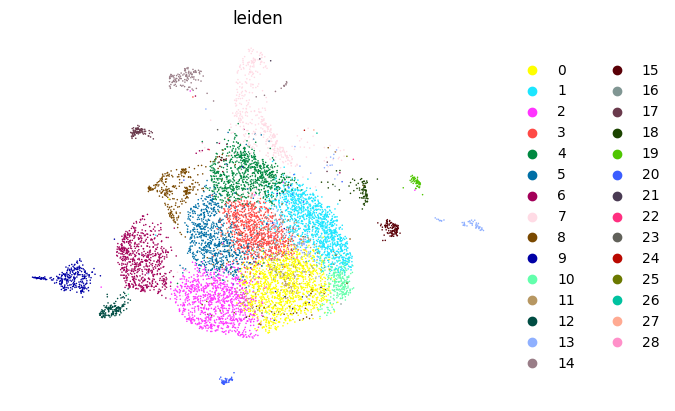

In [7]:
# Leiden clustering with resolution 2
sc.tl.leiden(adata_pertubed, resolution=1)
# Plot UMAP
sc.pl.umap(adata_pertubed, color=['leiden'],
           color_map = 'RdPu', ncols = 3, #legend_loc='on data',
           size=5,
           legend_fontsize=10,
           frameon=False,
           show=False
           )
# plt.savefig(f'{figures_folder}{today}_perturbed_leiden_res_1.pdf')

In [80]:
#select all guides by selecting the names which do not start with ENSG in var_names
targeted_tf_guides = list(adata_pertubed.var_names[~adata_pertubed.var_names.str.startswith('ENSG')])
#use list comprehension to split targeted_tf_guides by '_' and select the first element of the list
targeted_tf = [x.split('_')[0] for x in targeted_tf_guides]

In [81]:
ipsc_tf = ['SOX2', 'KLF4', 'POU5F1', 'NANOG']
cell_cycle = ['MKI67', 'PCNA']
targeted_tf_guides, targeted_tf, ipsc_tf, cell_cycle

(['AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAGAGCGA_1',
  'AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAGAGCGA_2',
  'AIRE_ATCACAGGGAAGTGTCCCTG_AIRE_CAGGGAAGTGTCCCTGCGGG_1',
  'AIRE_ATCACAGGGAAGTGTCCCTG_AIRE_CAGGGAAGTGTCCCTGCGGG_2',
  'ASCL1_AGCCGCTCGCTGCAGCAGCG_ASCL1_GGAGGGGGAGTTTAGGGAGT_1',
  'ASCL1_AGCCGCTCGCTGCAGCAGCG_ASCL1_GGAGGGGGAGTTTAGGGAGT_2',
  'ASCL1_CTCCCCGCTGCTGCAGCGAG_ASCL1_GCAGCCGCTCGCTGCAGCAG_1',
  'ASCL1_CTCCCCGCTGCTGCAGCGAG_ASCL1_GCAGCCGCTCGCTGCAGCAG_2',
  'DBX2_CCGTCCAGATCTGCATAGAG_DBX2_GTCCAGATCTGCATAGAGAG_1',
  'DBX2_CCGTCCAGATCTGCATAGAG_DBX2_GTCCAGATCTGCATAGAGAG_2',
  'DBX2_GCTCCCAGAGCCTACGCTGT_DBX2_GTTTCTCTGGCCGACAGCGT_1',
  'DBX2_GCTCCCAGAGCCTACGCTGT_DBX2_GTTTCTCTGGCCGACAGCGT_2',
  'DLX1_AAAGCTTTGAACCGAGTTTG_DLX1_CCAGTGATTATGCAAGACAG_1',
  'DLX1_AAAGCTTTGAACCGAGTTTG_DLX1_CCAGTGATTATGCAAGACAG_2',
  'DLX1_GTGTGGATGCGTCTTACCCG_DLX1_TAAGACGCATCCACACTTCC_1',
  'DLX1_GTGTGGATGCGTCTTACCCG_DLX1_TAAGACGCATCCACACTTCC_2',
  'DLX5_ACAAAGCATTGCTTAAAAAG_DLX5_GGGTGTTACTGTTG

In [82]:
expected_guides = [
    'AIRE',
    'ASCL1',
    'DLX1',
    'IRF3',
    'LHX6',
    'MAFB',
    'MYOD1',
    'NEUROG2',
    'OLIG2',
    'PROX1',
    'RORA',
    'RORB',
    'SATB2',
    'sgRNA1_SCP',
    'sgRNA6_SCP',
    'ONE_INTERGENIC_SITE_1194'
]

#filter targeted_tf_guides to only include guides which start with the expected_tfs
targeted_tf_guides = [x for x in targeted_tf_guides if x.split('_')[0] in expected_guides]

In [1]:
targeted_tf_guides

NameError: name 'targeted_tf_guides' is not defined

In [15]:
expected_tf = [
    'AIRE',
    'ASCL1',
    'DLX1',
    'IRF3',
    'LHX6',
    'MAFB',
    'MYOD1',
    'NEUROG2',
    'OLIG2',
    'PROX1',
    'RORA',
    'RORB',
    'SATB2'
]

In [16]:
len(expected_tf)

13

In [83]:
len(np.unique(targeted_tf)), len(expected_guides)

(23, 16)

/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


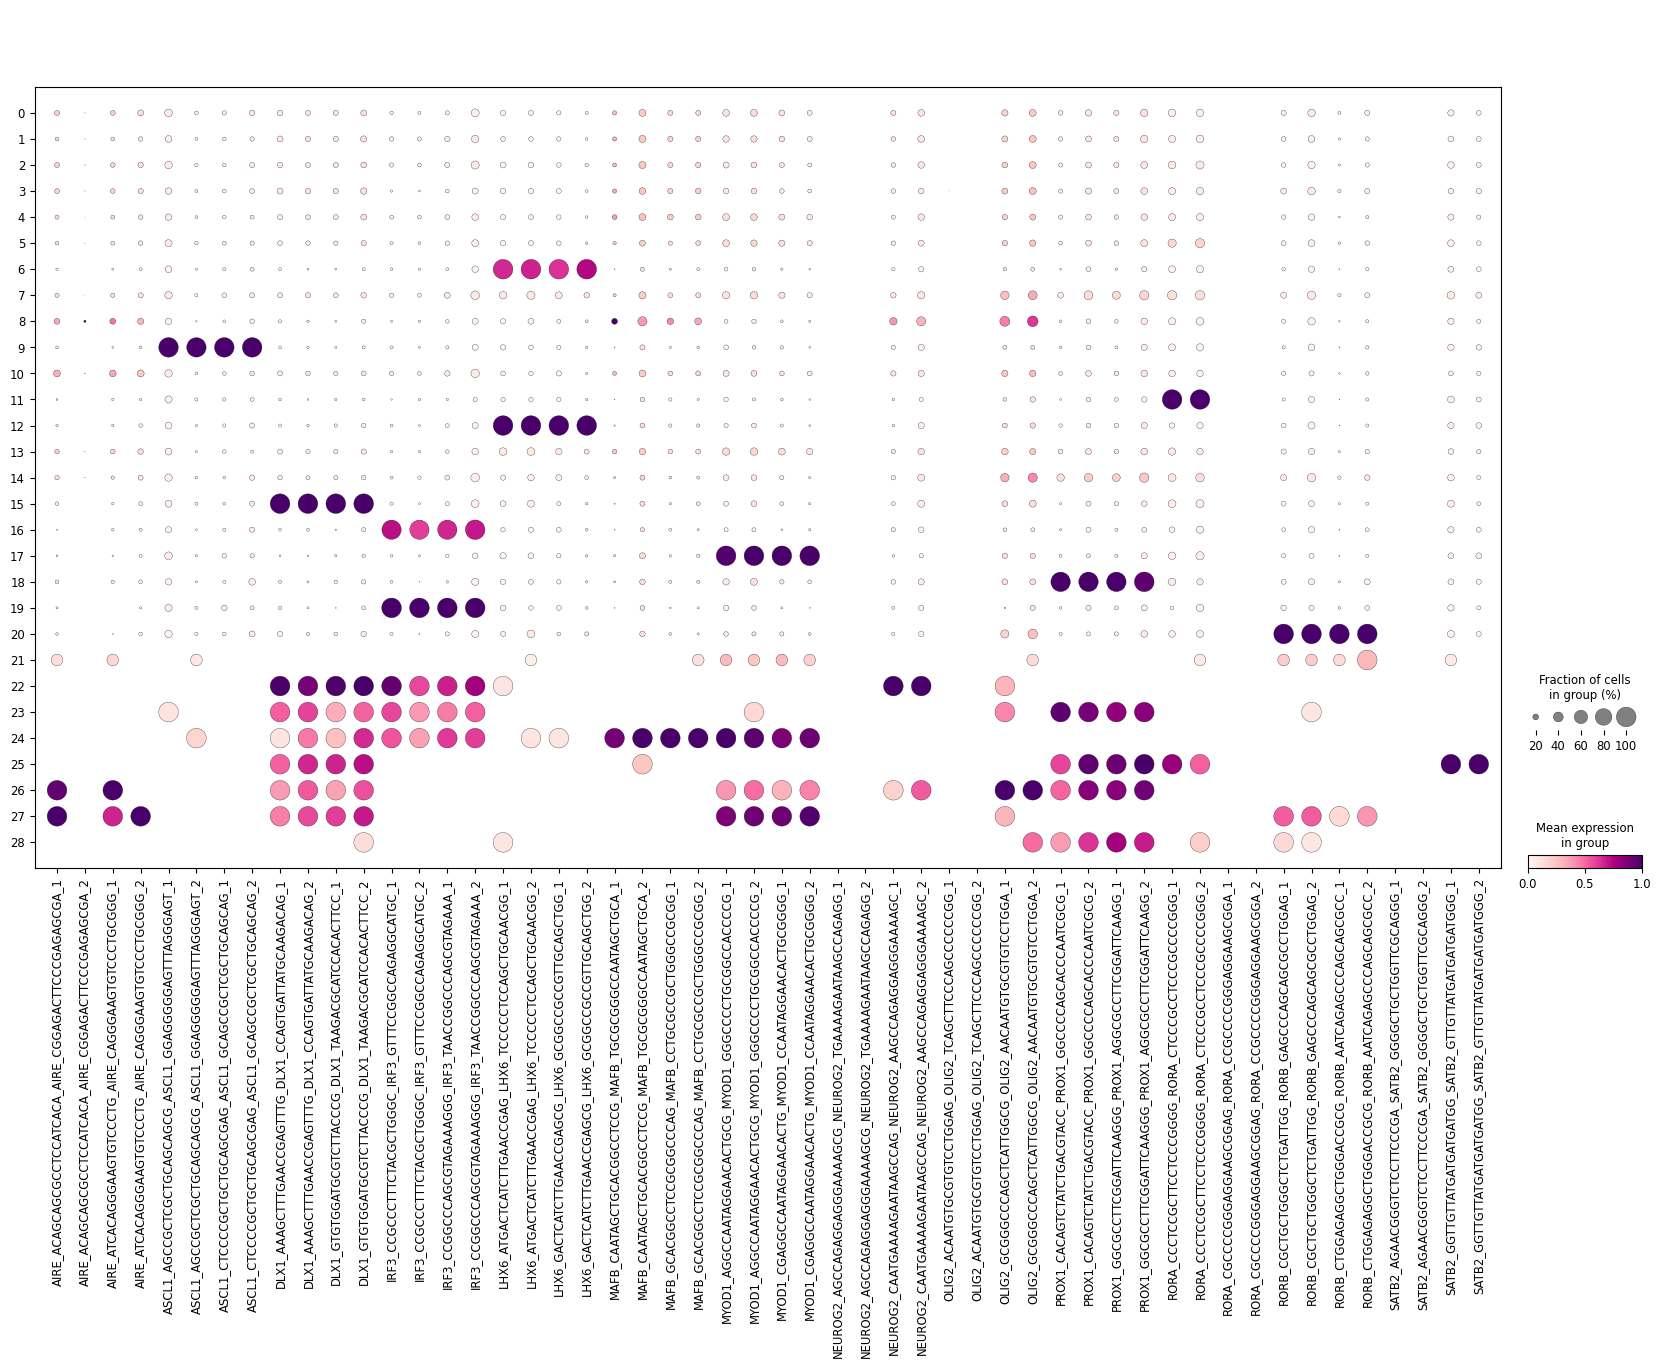

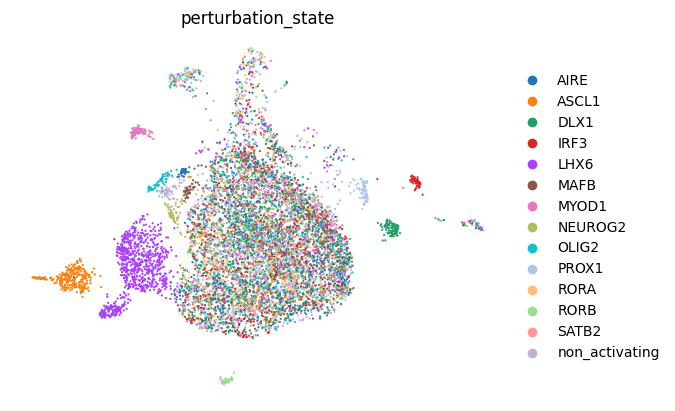

In [84]:
sc.pl.dotplot(adata_pertubed, targeted_tf_guides ,
              standard_scale='var',
              groupby='leiden', color_map = 'RdPu',
              gene_symbols='SYMBOL', show=False)
#save plot 
# plt.savefig(f'{figures_folder}{today}_dotplot_guides_cluster.pdf',bbox_inches='tight')

sc.pl.umap(adata_pertubed, color=['perturbation_state'],
           color_map='RdPu', ncols=4, #legend_loc='on data',
           vmin=0, vmax='p99.999', size=10,
           legend_fontsize=10, gene_symbols='SYMBOL',show=False,frameon=False)
#save plot
plt.savefig(f'{figures_folder}{today}_umap_perturbed_state.pdf',bbox_inches='tight')


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:39

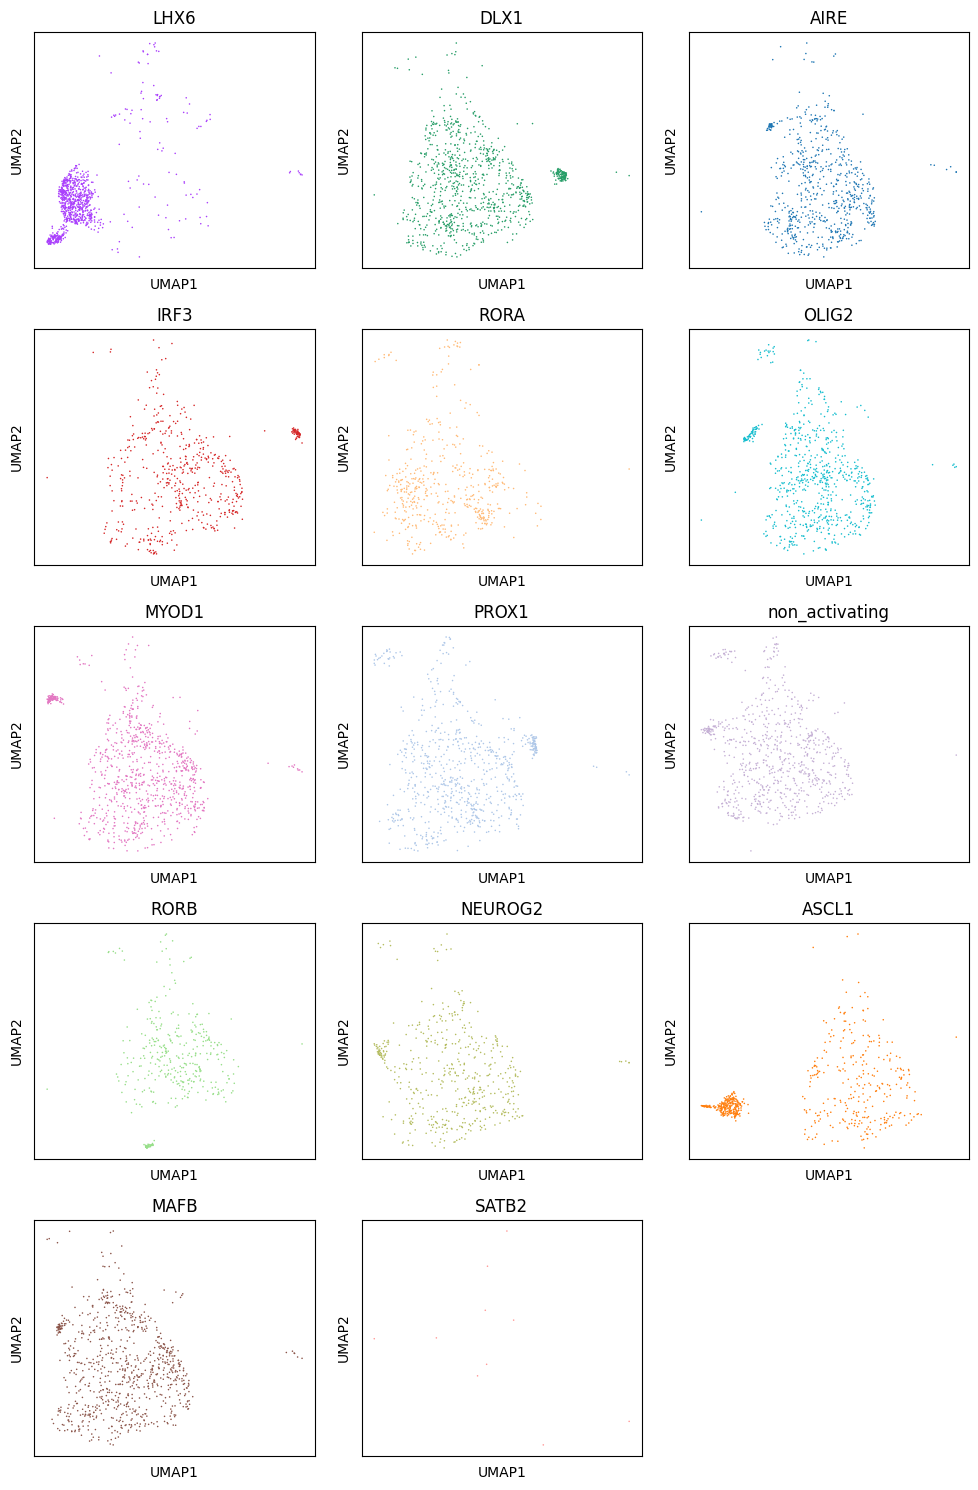

In [66]:
perturbation_states = adata_pertubed.obs['perturbation_state'].unique()
n_rows = 5
#round up to get the number of rows

n_cols = np.round(len(perturbation_states)/n_rows).astype(int)
#use plt.subplots to create a figure with the number of rows and columns increase spacing between subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 15))
axes = axes.ravel()

for i, perturbation_state in enumerate(perturbation_states):
    adata_pertubed_state = adata_pertubed[adata_pertubed.obs['perturbation_state'] == perturbation_state]
    sc.pl.umap(adata_pertubed_state, color=['perturbation_state'],
                color_map='RdPu', ncols=4, #legend_loc='on data',
                size=5,
                legend_fontsize=10, gene_symbols='SYMBOL', ax=axes[i], show=False, legend_loc=None)
    #tight bbox
    plt.tight_layout()
    axes[i].set_title(perturbation_state)
#remove the axis from the last subplot as it is empty
axes[14].set_axis_off()


plt.savefig(f'{figures_folder}{today}_umap_targeting_plasmids_perturbed_state.pdf',bbox_inches='tight')            

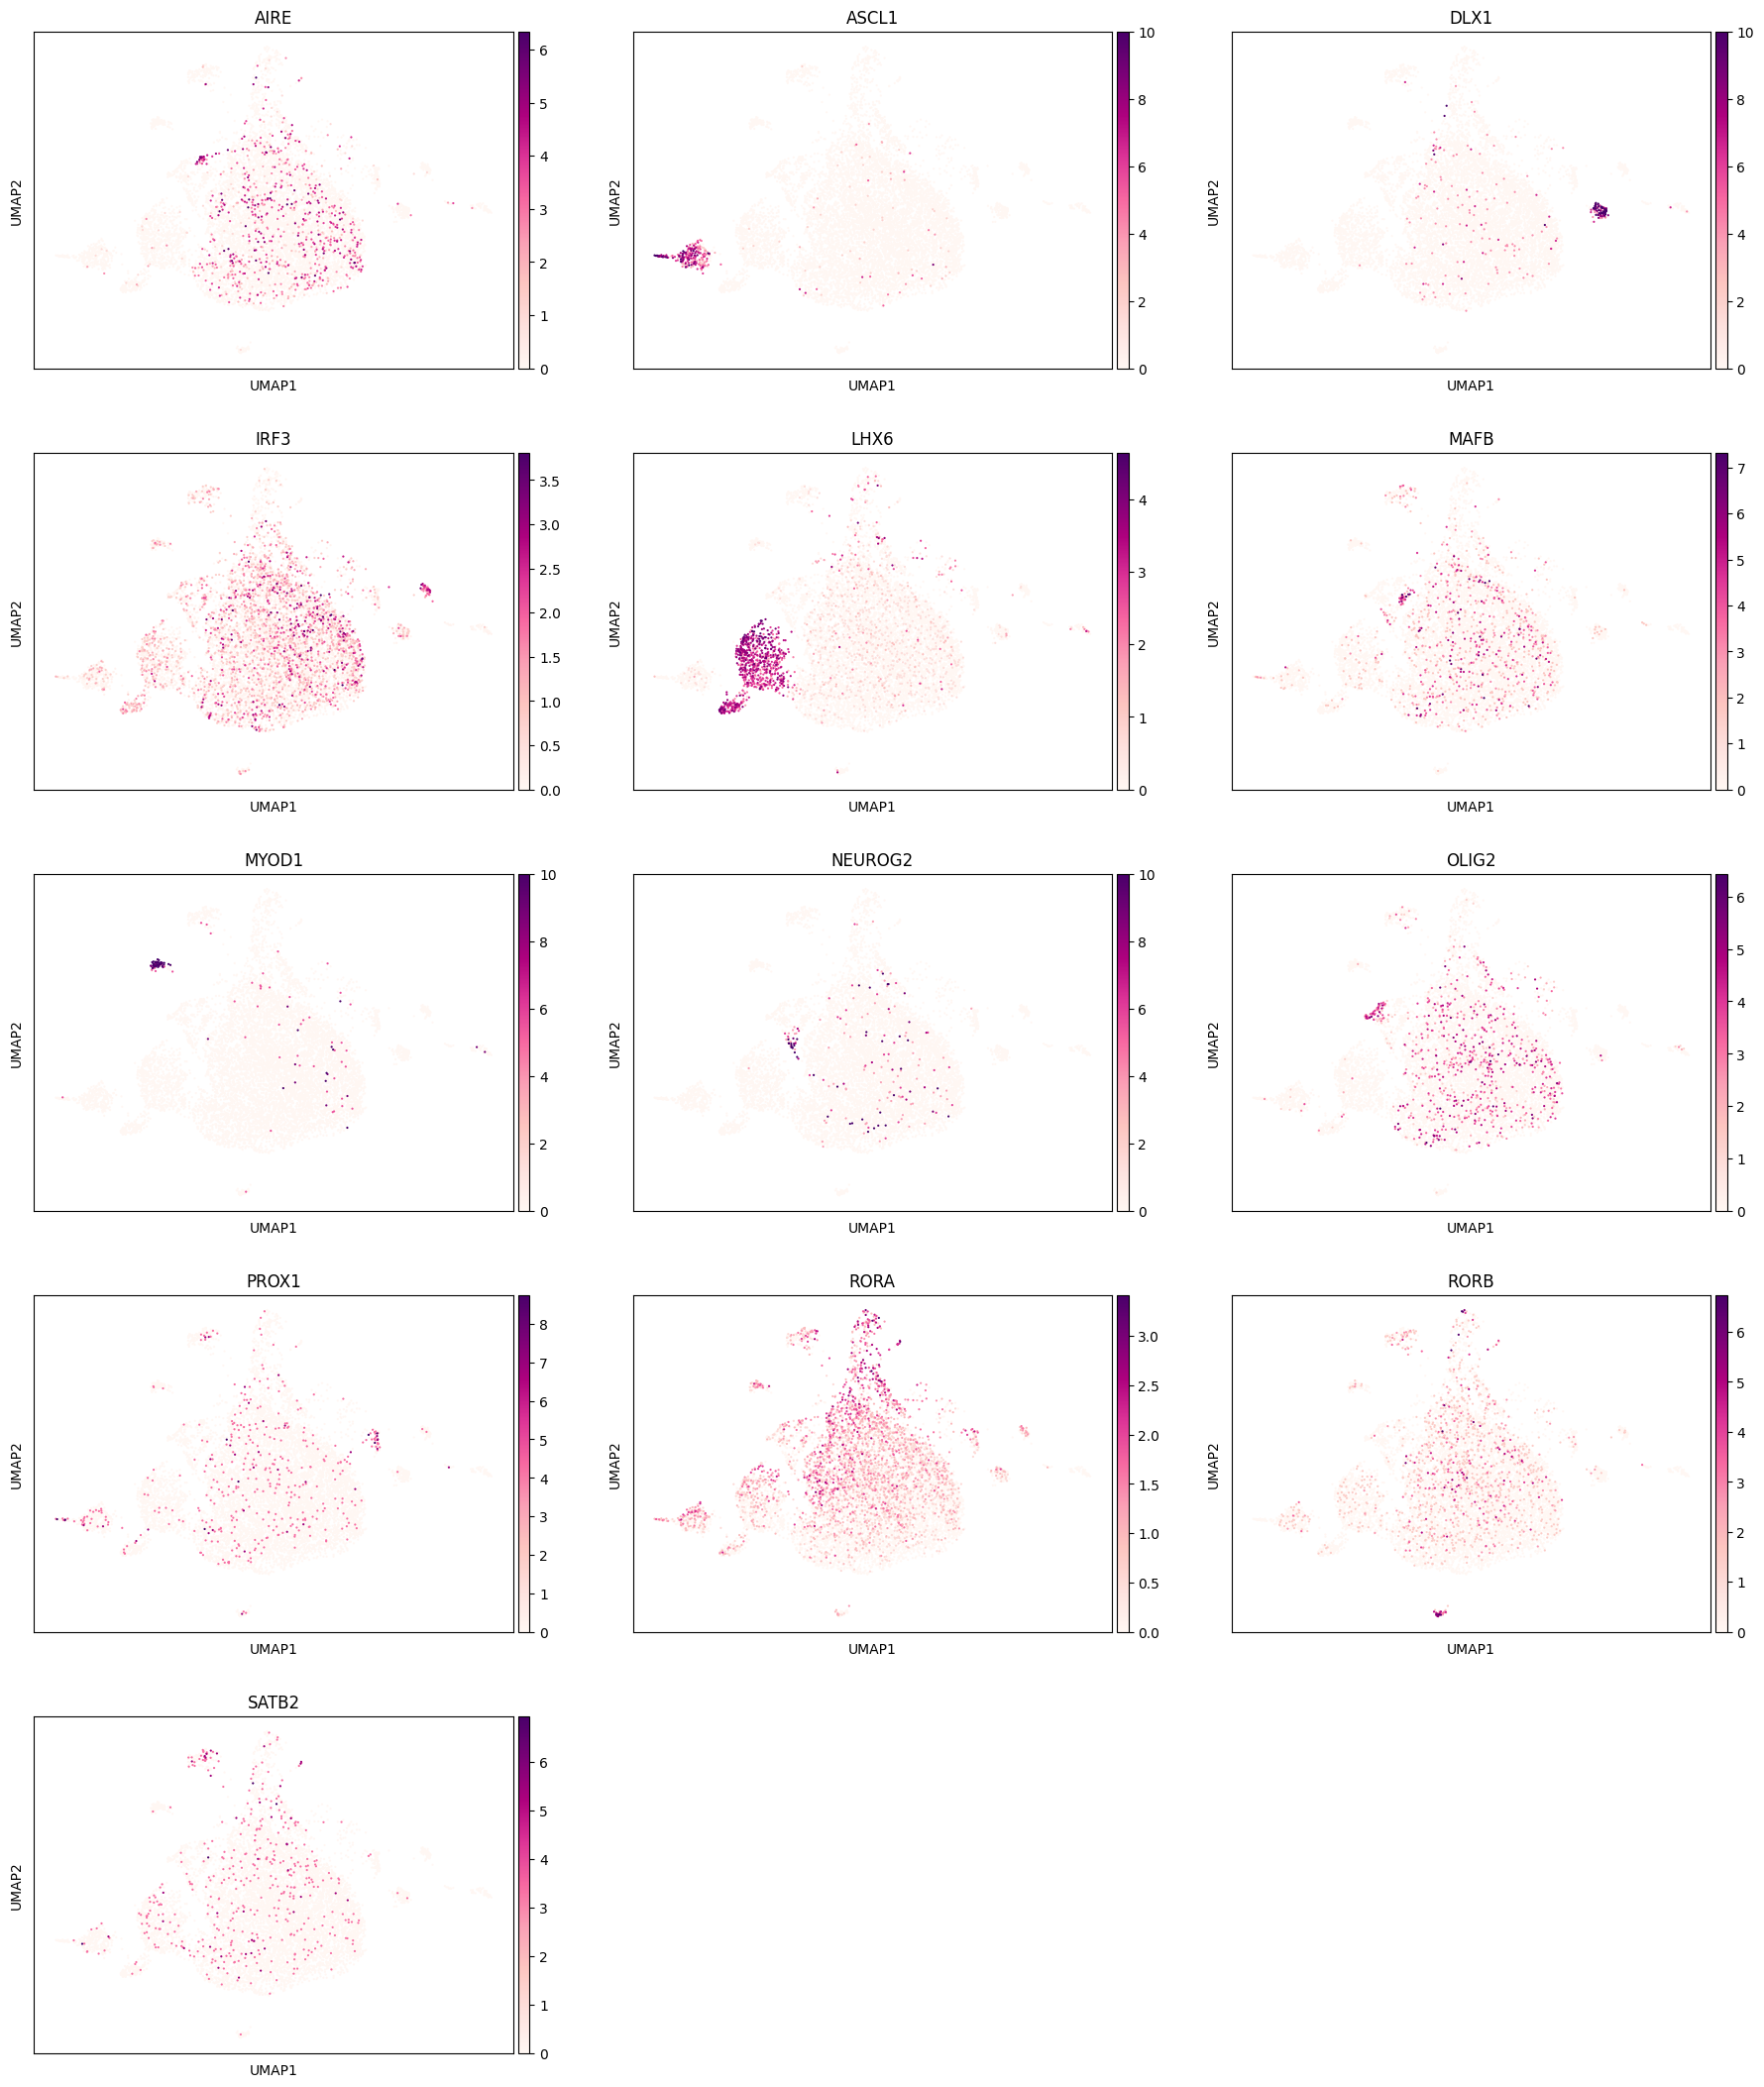

In [50]:
sc.pl.umap(adata_pertubed, color=expected_tf,
           color_map='RdPu', ncols=3, #legend_loc='on data',
           vmin=0, vmax='p99.99', size=10,
           legend_fontsize=10, gene_symbols='SYMBOL')

/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: Runtim

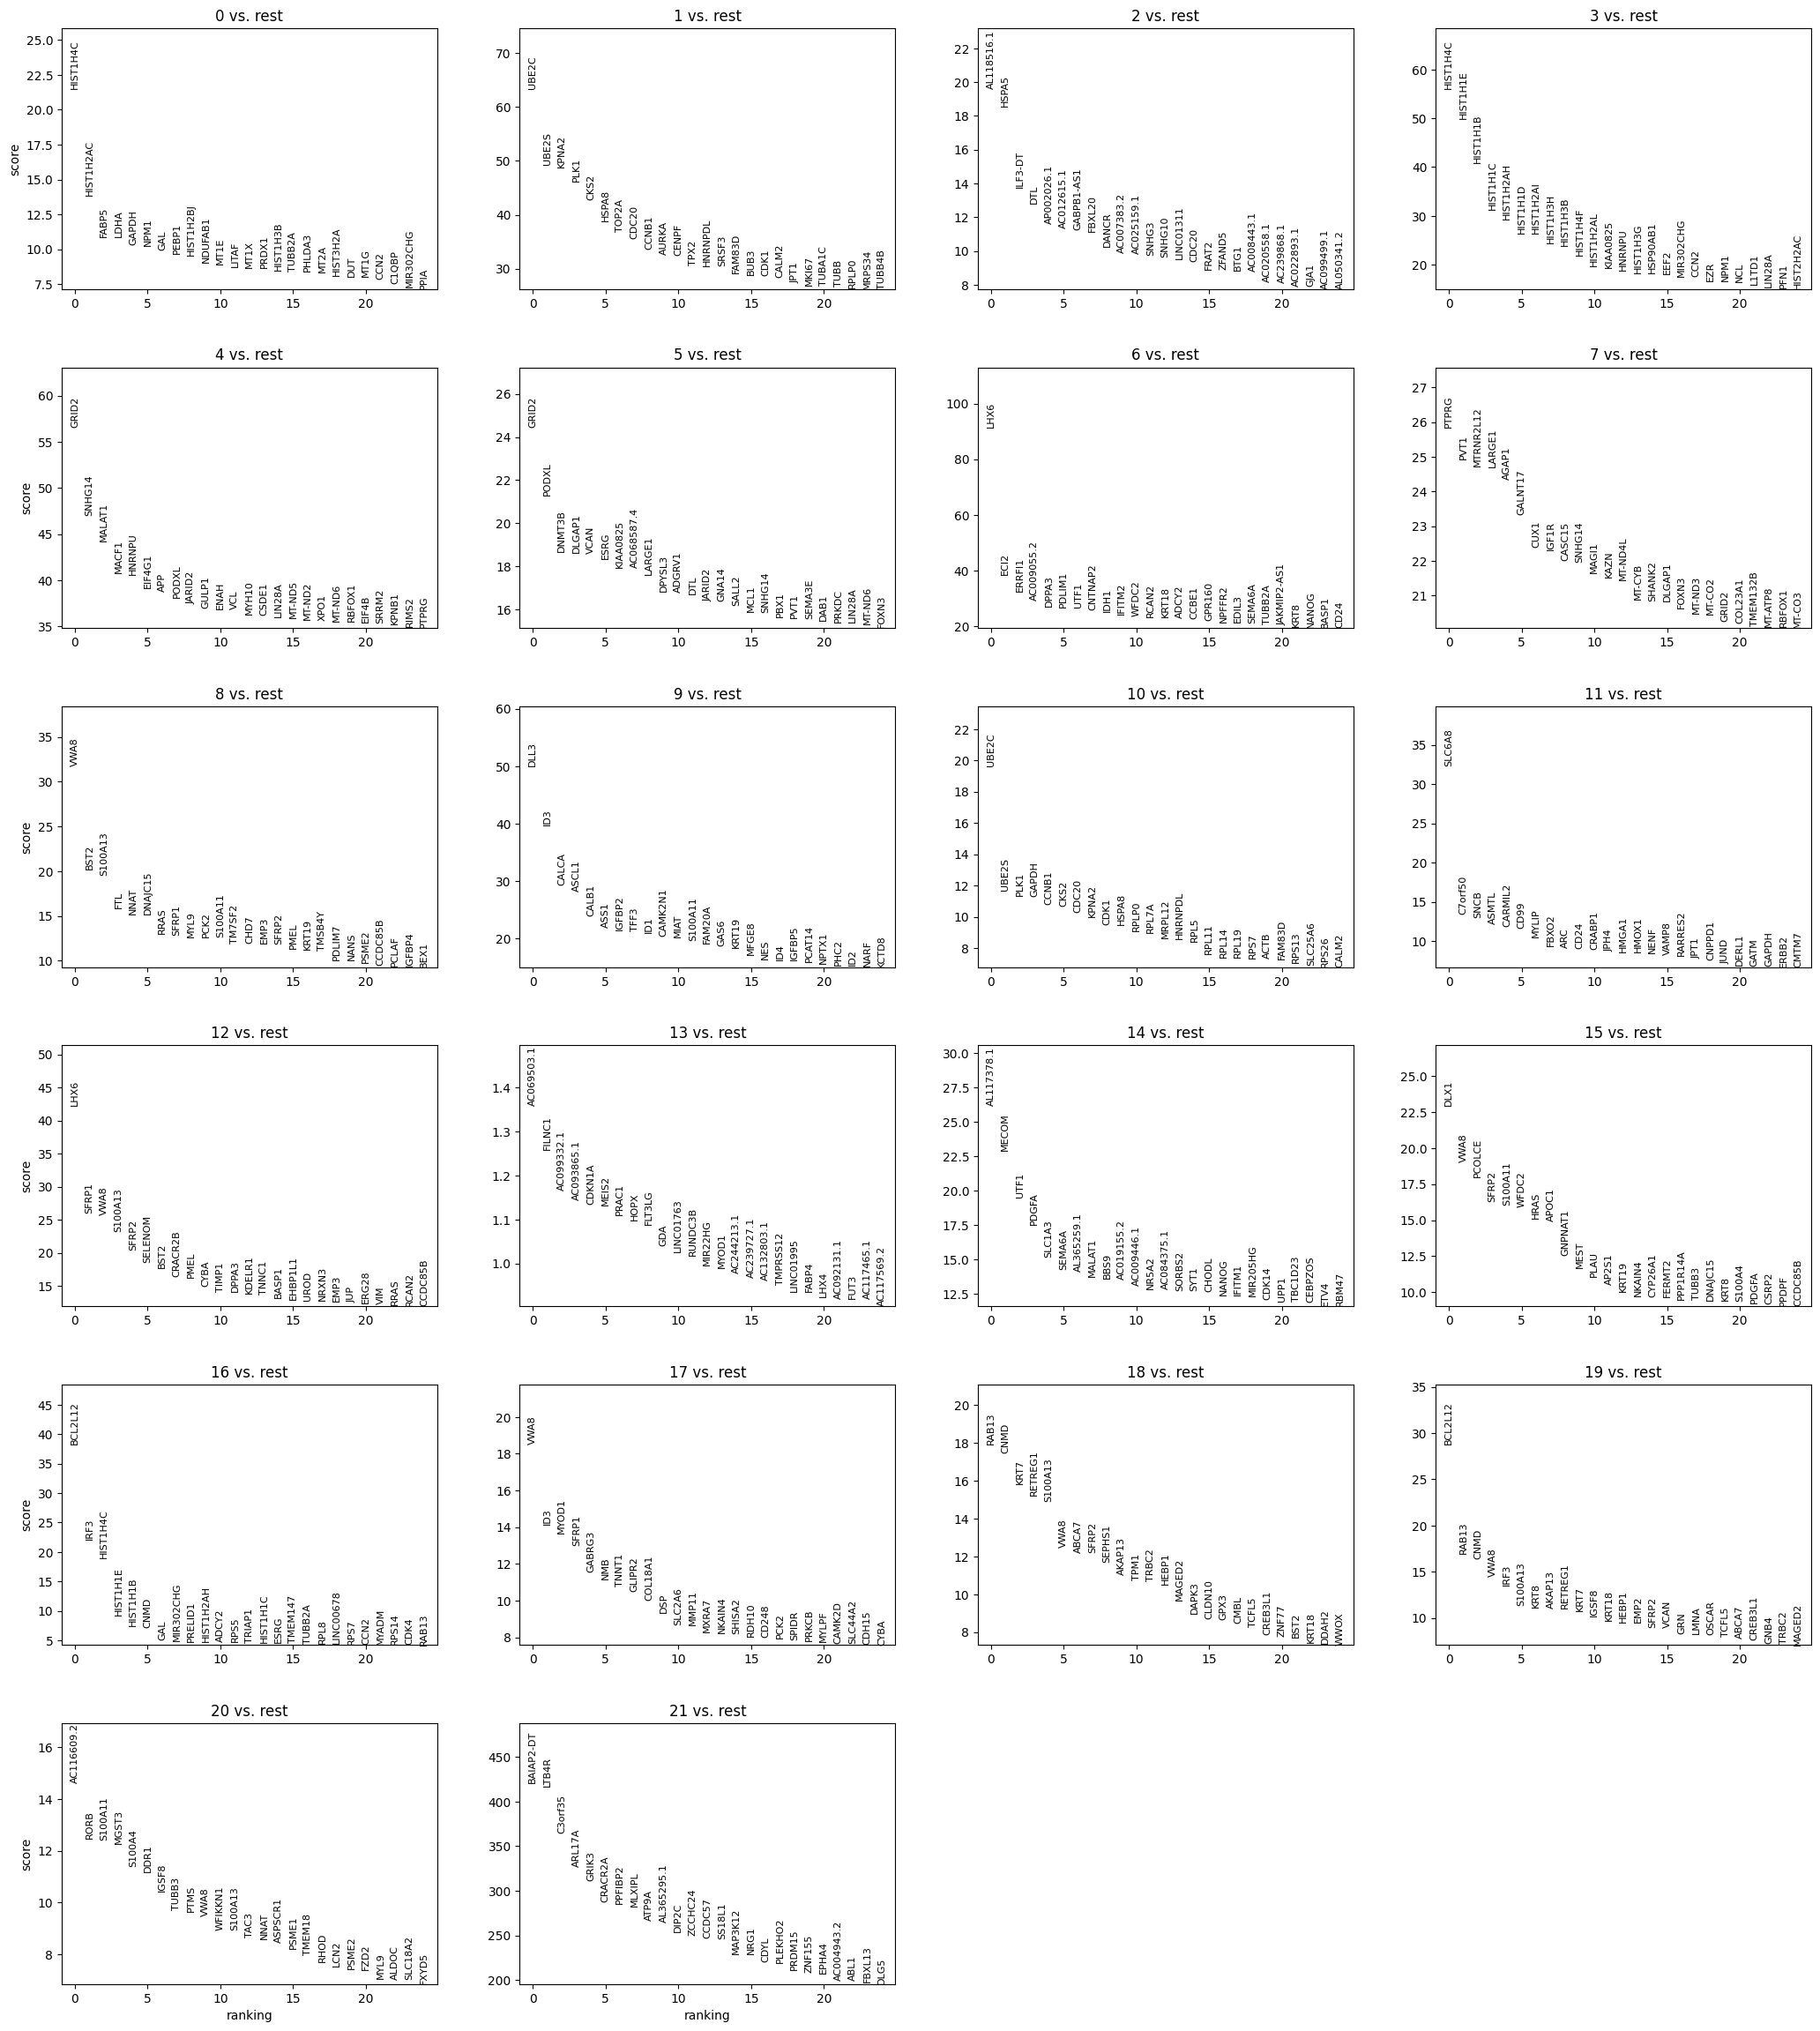

In [11]:
#create log1p and save to adata_pertubed base layer
adata_pertubed.uns['log1p']["base"] = None
#excluding leiden clusters with only 1 cell based on adata obs
adata_filter_leiden=adata_pertubed.obs['leiden'].value_counts()[adata_pertubed.obs['leiden'].value_counts() > 1].index.tolist()
#filter adata_pertubed to only include leiden clusters with ffmore than 1 cell
adata_filter_leiden = adata_pertubed[adata_pertubed.obs['leiden'].isin(adata_filter_leiden)]
#filter out guides from gene list in adata var which do not start with ENSG
adata_filter_leiden = adata_filter_leiden[:, adata_filter_leiden.var_names.str.startswith('ENSG')]

sc.tl.rank_genes_groups(adata_filter_leiden, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata_filter_leiden, n_genes=25, sharey=False, gene_symbols='SYMBOL')

In [14]:
adata_filter_leiden

AnnData object with n_obs × n_vars = 8928 × 15907
    obs: 'barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', 'perturbation_state', 'leiden'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'nonz_mean', 'mean', 'std'
    uns: 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
#compare to clean ipsc data 